In [15]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
import yfinance as yf   

In [16]:
df = yf.download('BTC-USD')

[*********************100%***********************]  1 of 1 completed


In [17]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [21]:
print(df.columns)
if 'Date' not in df.columns:
    df = df.reset_index()
df = df[['Date', 'Close']]

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [22]:
print(df.columns)

Index(['Date', 'Close'], dtype='object')


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3630 entries, 0 to 3629
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3630 non-null   datetime64[ns]
 1   Close   3630 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 56.8 KB


In [24]:
df['Date'].min(), df['Date'].max()

(Timestamp('2014-09-17 00:00:00'), Timestamp('2024-08-24 00:00:00'))

In [25]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Bitcoin close price history')
fig.show()

In [29]:
train = df.loc[df['Date'] <= '2017-09-17']
test = df.loc[df['Date'] > '2017-09-17']
train.shape, test.shape

((1097, 2), (2533, 2))

In [30]:
scaler = StandardScaler()
scaler = scaler.fit(np.array(train['Close']).reshape(-1, 1))

train['Close'] = scaler.transform(np.array(train['Close']).reshape(-1, 1))
test['Close'] = scaler.transform(np.array(test['Close']).reshape(-1, 1))

/var/folders/b8/w5gq0wdx1pbbwwjv87lm8c_c0000gn/T/ipykernel_3773/2980375279.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/b8/w5gq0wdx1pbbwwjv87lm8c_c0000gn/T/ipykernel_3773/2980375279.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



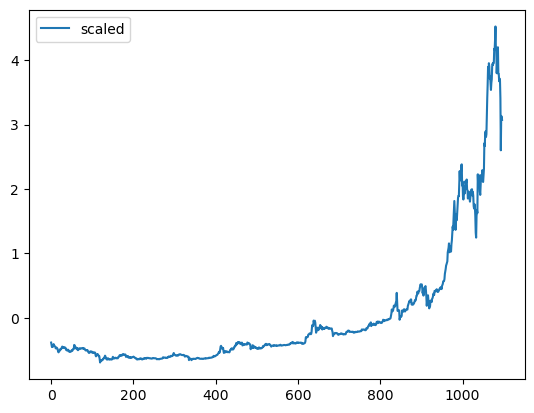

In [31]:
plt.plot(train['Close'], label='scaled')
plt.legend()
plt.show()


In [36]:
TIME_STEPS = 30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X) - time_steps):
        X_out.append(X.iloc[i:(i + time_steps)].values)
        y_out.append(y.iloc[i + time_steps])
    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])
print("Training input shape: ", X_train.shape)
print("Training output shape: ", X_test.shape)

Training input shape:  (1067, 30, 1)
Training output shape:  (2503, 30, 1)


In [37]:
np.random.seed(21)
tf.random.set_seed(21)

In [38]:
X_train[0]

array([[-0.38396929],
       [-0.42037684],
       [-0.45318724],
       [-0.43757231],
       [-0.44873229],
       [-0.4450455 ],
       [-0.40781342],
       [-0.42174377],
       [-0.4346171 ],
       [-0.44252974],
       [-0.44795866],
       [-0.47268376],
       [-0.47458083],
       [-0.46187794],
       [-0.46556253],
       [-0.47501804],
       [-0.49224006],
       [-0.52615947],
       [-0.535408  ],
       [-0.5248169 ],
       [-0.51805647],
       [-0.49951403],
       [-0.48613708],
       [-0.48997107],
       [-0.48915535],
       [-0.47116963],
       [-0.45803729],
       [-0.44646445],
       [-0.45321268],
       [-0.46673464]])

In [39]:
model = Sequential()
model.add(LSTM(128, activation='tanh',input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 1)          │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode=min)],shuffle=False)

Epoch 1/100


/var/folders/b8/w5gq0wdx1pbbwwjv87lm8c_c0000gn/T/ipykernel_3773/3013859167.py:1: UserWarning:

EarlyStopping mode <built-in function min> is unknown, fallback to auto mode.



30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0843 - val_loss: 1.1530
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0195 - val_loss: 1.0181
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0388 - val_loss: 5.1006
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0472 - val_loss: 0.5388
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0211 - val_loss: 0.8086
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0291 - val_loss: 3.1062
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0157 - val_loss: 0.3611
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0137 - val_loss: 0.3942
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0220 - val_loss: 2.4325
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0090 - val_loss: 0.3951
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0101 - val_loss: 0.3945
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0

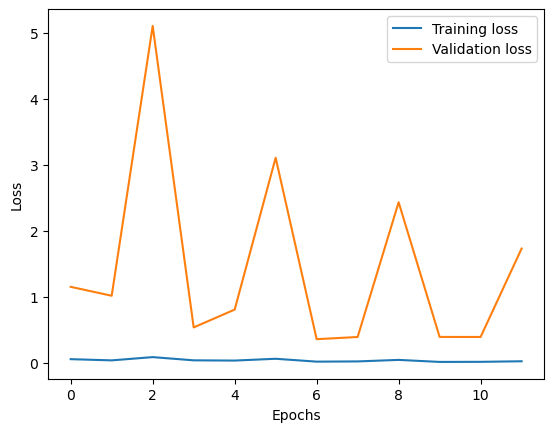

In [41]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Reconstruction error threshold:  2.095668074944691


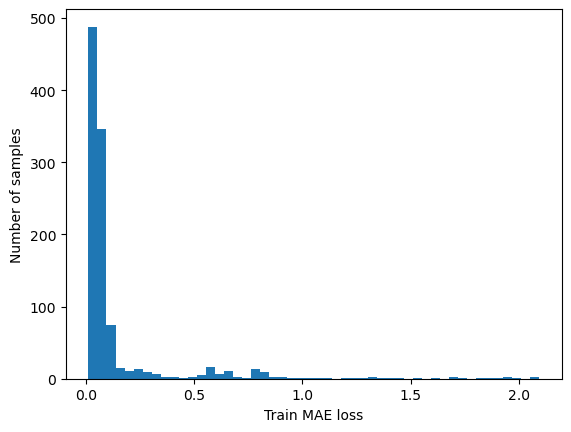

In [42]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of samples')
threshold = np.max(train_mae_loss)


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


Text(0, 0.5, 'Number of samples')

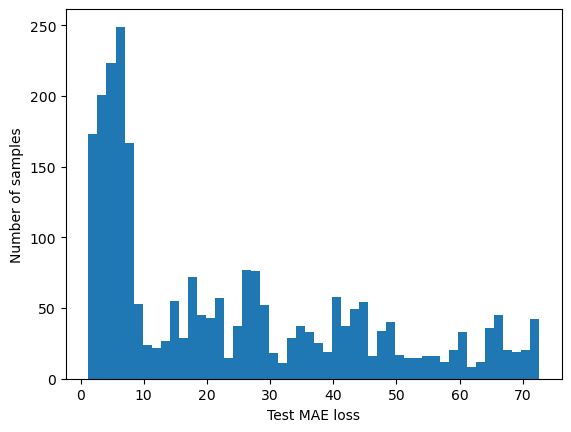

In [44]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')


In [45]:
anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [46]:
anomaly_df.head()

,Date,Close,loss,threshold,anomaly
1127,2017-10-18,5.297700,1.662301,2.095668,False
1128,2017-10-19,5.428116,1.720405,2.095668,False
1129,2017-10-20,5.763404,1.777130,2.095668,False
1130,2017-10-21,5.785706,1.822017,2.095668,False
1131,2017-10-22,5.760050,1.889138,2.095668,False


In [47]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['loss'], name='Test loss'))  
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [48]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,Date,Close,loss,threshold,anomaly
1134,2017-10-25,5.474912,2.148827,2.095668,True
1135,2017-10-26,5.645395,2.219191,2.095668,True
1136,2017-10-27,5.508227,2.282576,2.095668,True
1137,2017-10-28,5.477447,2.345790,2.095668,True
1138,2017-10-29,5.921014,2.409537,2.095668,True


In [49]:
anomalies.shape

(2367, 5)

In [51]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df[['Close']]), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=scaler.inverse_transform(anomalies[['Close']]), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()